In [1]:
import Atlas
import numpy as np
from scipy.stats import norm

In [2]:
try:
    tape = Atlas.Tape()
except:
    pass

In [13]:
evalDate = Atlas.Date(1, Atlas.August, 2020)
store = Atlas.MarketStore(evalDate, Atlas.CLP()) # store with CLP as base currency

# define curve
dayCounter = Atlas.Actual360()
compounding = Atlas.Simple
frequency = Atlas.Annual
clpRate = Atlas.Dual(0.03)

# we need to register the input to the tape for later use
tape.registerInput(clpRate) 
tape.newRecording() # start recording, for later use

# add CLP Curve
strategy = Atlas.FlatForwardStrategy(evalDate, clpRate, dayCounter, compounding, frequency)
clpCurve = Atlas.YieldTermStructure(strategy)
index = Atlas.RateIndex(evalDate, frequency, dayCounter, frequency, compounding)
store.addCurve("CLP", clpCurve, index)

In [14]:
# Create the instrument with random parameters
startDate = Atlas.Date(1, Atlas.August, 2020)
endDate = Atlas.Date(1, Atlas.August, 2020+20)
rateValue = Atlas.Dual(0.024020800128600035)

rate = Atlas.InterestRate(rateValue, dayCounter, compounding, frequency)
discountContext = store.curveContext("CLP")
rateIndexContext = store.rateIndexContext("CLP")
spread = Atlas.Dual(0.0)
notional = 10_000
paymentFrequency = Atlas.Semiannual
# random side
side = Atlas.Payer
instrument = Atlas.FixFloatSwap(startDate, endDate, notional, rate, spread, paymentFrequency, rateIndexContext, side)
instrument.firstLeg().discountCurveContext(discountContext)
instrument.secondLeg().discountCurveContext(discountContext)

In [15]:
indexer = Atlas.Indexer()
indexer.visit(instrument)
request = indexer.request()

model = Atlas.SpotMarketDataModel(request, store)
marketData = model.marketData(evalDate)

In [16]:
leg = instrument.firstLeg()
def annuity(evalDate):
    a  = 0.0
    for cf in leg.coupons():
        if not cf.hasOcurred(evalDate):
            idx = cf.dfIdx()
            df = Atlas.getValue(marketData.dfs[idx])
            if cf.startDate() > evalDate:
                a += df * cf.accruedPeriod(cf.startDate(), cf.endDate())
            else:
                a += df * cf.accruedPeriod(evalDate, cf.endDate())
    return a

annuity(evalDate)

15.752988092550773

In [17]:
npv = Atlas.Dual(0.0)
tape.registerOutput(npv)

npvCalculator = Atlas.NPVCalculator(marketData)
npvCalculator.visit(instrument)
npv = npvCalculator.results()
print("NPV: {:.4f}".format(Atlas.getValue(npv)))

NPV: 0.0000


In [18]:
def fairRate(evalDate):
    df0 = 0.0
    df0 = Atlas.getValue(strategy.discount(evalDate))
    idxT = leg.coupons()[-1].dfIdx()
    dfT = Atlas.getValue(marketData.dfs[idxT])
    c    = (df0 - dfT) / annuity(evalDate)
    return c

In [19]:
def black76(side, F, K, sigma, P, evalDate, endDate, dayCounter):    
    T = dayCounter.yearFraction(evalDate, endDate, evalDate, endDate)
    if T == 0 or F == 0 or sigma == 0:
        return 0
    d1 = (np.log(F)-np.log(K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if side == Atlas.Payer:
        return P * (F * norm.cdf(d1) - K * norm.cdf(d2))
    return P * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

In [20]:
sigma = 0.2
K = Atlas.getValue(rateValue)
N = instrument.notional()
exposure = []
ann = []
rates = []
for i in range(len(leg.coupons())):
    cf = leg.coupons()[i]
    if not cf.hasOcurred(marketData.refDate):    
        startDate = cf.startDate()        
        c = fairRate(startDate)
        df = Atlas.getValue(strategy.discount(startDate))
        e = black76(side, c, K, sigma, df, evalDate, startDate, dayCounter)
        a = annuity(startDate)
        exposure.append(e*a*N)
        
        idx = cf.dfIdx()
        df = Atlas.getValue(strategy.discount(endDate))
        endDate = cf.endDate()
        if endDate < instrument.endDate():
            c = fairRate(endDate)
            e = black76(side, c, K, sigma, df, evalDate, endDate, dayCounter)
            a = annuity(endDate)
            exposure.append(e*a*N)
            


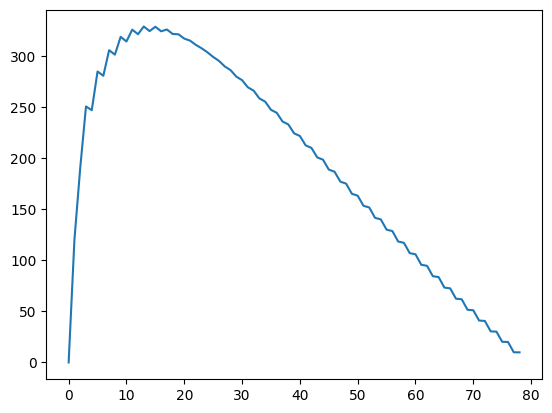

In [21]:
import matplotlib.pyplot as plt
plt.plot(exposure)

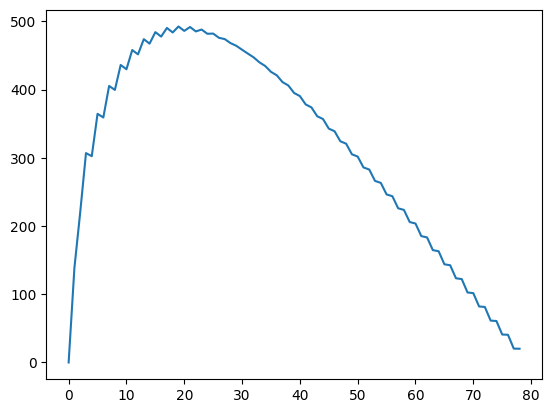

In [12]:
import matplotlib.pyplot as plt
plt.plot(exposure)